# **Predicting the Risk of Default on Home Credit** 

**A Data Science Approach to Supporting Credit Granting Decisions**

This project aims to predict loan default risk using the Home Credit Default Risk dataset, which contains customer information, credit history, and previous payments. The data is analyzed in depth to understand patterns, clean the data, and combine multiple sources for more information. The results are used to build machine learning and deep learning models that can help companies assess creditworthiness more accurately.

## **1.Import Library** 
Import all the libraries needed for data analysis, machine learning, and deep learning. This includes libraries for visualization, preprocessing, traditional models, and deep learning frameworks (TensorFlow and PyTorch).

In [35]:
# Import Base Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Visual style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Import Machine Learning Library
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
import lightgbm as lgb

# Import Deep Learning Library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## **2. Load Data and Initialization**

Loads the primary dataset and supplementary datasets for analysis. The primary dataset contains credit application information, while the supplementary dataset contains credit history, payment, and credit behavior information.

In [36]:
# Load Data in Every File
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')
bureau = pd.read_csv('data/bureau.csv')
bureau_balance = pd.read_csv('data/bureau_balance.csv')
prev_app = pd.read_csv('data/previous_application.csv')
pos_cash = pd.read_csv('data/POS_CASH_balance.csv')
credit_card = pd.read_csv('data/credit_card_balance.csv')
installments = pd.read_csv('data/installments_payments.csv')

## **3. Data Understanding** 

### **3.1 Check Missing Value**

In [37]:
print("\n" + "="*50)
print("2. DATA PRE-PROCESSING")
print("="*50)

def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_train = check_missing_data(app_train)
print("Kolom dengan missing values > 50%:")
print(missing_train[missing_train['Percent'] > 50])


2. DATA PRE-PROCESSING
Kolom dengan missing values > 50%:
                           Total    Percent
COMMONAREA_MEDI           214865  69.872297
COMMONAREA_AVG            214865  69.872297
COMMONAREA_MODE           214865  69.872297
NONLIVINGAPARTMENTS_MODE  213514  69.432963
NONLIVINGAPARTMENTS_AVG   213514  69.432963
NONLIVINGAPARTMENTS_MEDI  213514  69.432963
FONDKAPREMONT_MODE        210295  68.386172
LIVINGAPARTMENTS_MODE     210199  68.354953
LIVINGAPARTMENTS_AVG      210199  68.354953
LIVINGAPARTMENTS_MEDI     210199  68.354953
FLOORSMIN_AVG             208642  67.848630
FLOORSMIN_MODE            208642  67.848630
FLOORSMIN_MEDI            208642  67.848630
YEARS_BUILD_MEDI          204488  66.497784
YEARS_BUILD_MODE          204488  66.497784
YEARS_BUILD_AVG           204488  66.497784
OWN_CAR_AGE               202929  65.990810
LANDAREA_MEDI             182590  59.376738
LANDAREA_MODE             182590  59.376738
LANDAREA_AVG              182590  59.376738
BASEMENTAREA_MEDI

## **4. Preprocessing Data dan Feature Engineering**

The preprocessing function handles missing values ​​and performs feature engineering. Numeric missing values ​​are filled with the median, and categorical values ​​with the value 'MISSING'. New features such as age, credit-to-income ratio, and family income are also created.

In [38]:
def preprocess_application_data(df):
    data = df.copy()
    
    # ----------------
    # Numeric missing -> median
    # ----------------
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if data[col].isnull().sum() > 0:
            data[col].fillna(data[col].median(), inplace=True)
    
    # ----------------
    # Categorical missing -> 'MISSING'
    # ----------------
    categorical_cols = data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if data[col].isnull().sum() > 0:
            data[col].fillna('MISSING', inplace=True)
    
    # ----------------
    # Feature engineering
    # ----------------
    # Age and years employed (convert to positive years)
    if 'DAYS_BIRTH' in data.columns:
        data['AGE'] = -data['DAYS_BIRTH'] / 365.25
    if 'DAYS_EMPLOYED' in data.columns:
        data['YEARS_EMPLOYED'] = -data['DAYS_EMPLOYED'] / 365.25
    
    # Income per family member: hati-hati pembagian nol
    # jika CNT_FAM_MEMBERS <= 0 -> gunakan 1 sebagai fallback
    if 'AMT_INCOME_TOTAL' in data.columns and 'CNT_FAM_MEMBERS' in data.columns:
        cnt = data['CNT_FAM_MEMBERS'].replace(0, np.nan)  # ubah 0 jadi NaN sementara
        income = data['AMT_INCOME_TOTAL']
        data['INCOME_PER_FAMILY'] = income / cnt
        # Untuk baris yang menjadi inf atau NaN karena cnt NaN (sebelumnya 0), isi fallback:
        mask_bad = ~np.isfinite(data['INCOME_PER_FAMILY'])
        # fallback: jika AMT_INCOME_TOTAL tersedia, gunakan AMT_INCOME_TOTAL (artinya asumsikan 1 anggota)
        data.loc[mask_bad, 'INCOME_PER_FAMILY'] = data.loc[mask_bad, 'AMT_INCOME_TOTAL']
        # Jika masih ada NaN (keduanya NaN), isi median
        data['INCOME_PER_FAMILY'].fillna(data['INCOME_PER_FAMILY'].median(), inplace=True)
    
    # Credit to income ratio
    if 'AMT_CREDIT' in data.columns and 'AMT_INCOME_TOTAL' in data.columns:
        # hindari pembagian oleh nol
        denom = data['AMT_INCOME_TOTAL'].replace(0, np.nan)
        data['CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / denom
        # ganti inf/NaN jadi 0 (jika income unknown, set 0 ratio)
        data.loc[~np.isfinite(data['CREDIT_TO_INCOME_RATIO']), 'CREDIT_TO_INCOME_RATIO'] = 0
    
    # Annuity to income ratio
    if 'AMT_ANNUITY' in data.columns and 'AMT_INCOME_TOTAL' in data.columns:
        denom = data['AMT_INCOME_TOTAL'].replace(0, np.nan)
        data['ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / denom
        data.loc[~np.isfinite(data['ANNUITY_TO_INCOME_RATIO']), 'ANNUITY_TO_INCOME_RATIO'] = 0
    
    return data

print("Preprocessing application data...")
app_train_processed = preprocess_application_data(app_train)
app_test_processed = preprocess_application_data(app_test)

Preprocessing application data...


## **5. Aggregated Features dari Data Bureau**

Create aggregate features from bureau data such as credit statistics, delinquencies, and debt amounts. These features provide historical information on borrowers' credit behavior.

In [39]:
print("Creating features from bureau data...")
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['sum', 'mean'],
    'AMT_CREDIT_SUM_DEBT': ['sum', 'mean']
}).reset_index()

# flatten columns
bureau_agg.columns = ['SK_ID_CURR'] + [
    'BUREAU_DAYS_CREDIT_MIN', 'BUREAU_DAYS_CREDIT_MAX', 'BUREAU_DAYS_CREDIT_MEAN',
    'BUREAU_CREDIT_DAY_OVERDUE_MAX', 'BUREAU_CREDIT_DAY_OVERDUE_MEAN',
    'BUREAU_AMT_CREDIT_SUM_SUM', 'BUREAU_AMT_CREDIT_SUM_MEAN',
    'BUREAU_AMT_CREDIT_SUM_DEBT_SUM', 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN'
]

app_train_final = app_train_processed.merge(bureau_agg, on='SK_ID_CURR', how='left')
app_test_final = app_test_processed.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Jika ada missing setelah merge -> isi median
app_train_final.fillna(app_train_final.median(numeric_only=True), inplace=True)
app_test_final.fillna(app_test_final.median(numeric_only=True), inplace=True)

Creating features from bureau data...


## **6. Exploratory Data Analysis**

Visualizations to understand data patterns and the relationship between features and targets. View default rates by income type, age group, and EXT_SOURCE correlation with targets.


3. DATA VISUALIZATION & INSIGHT


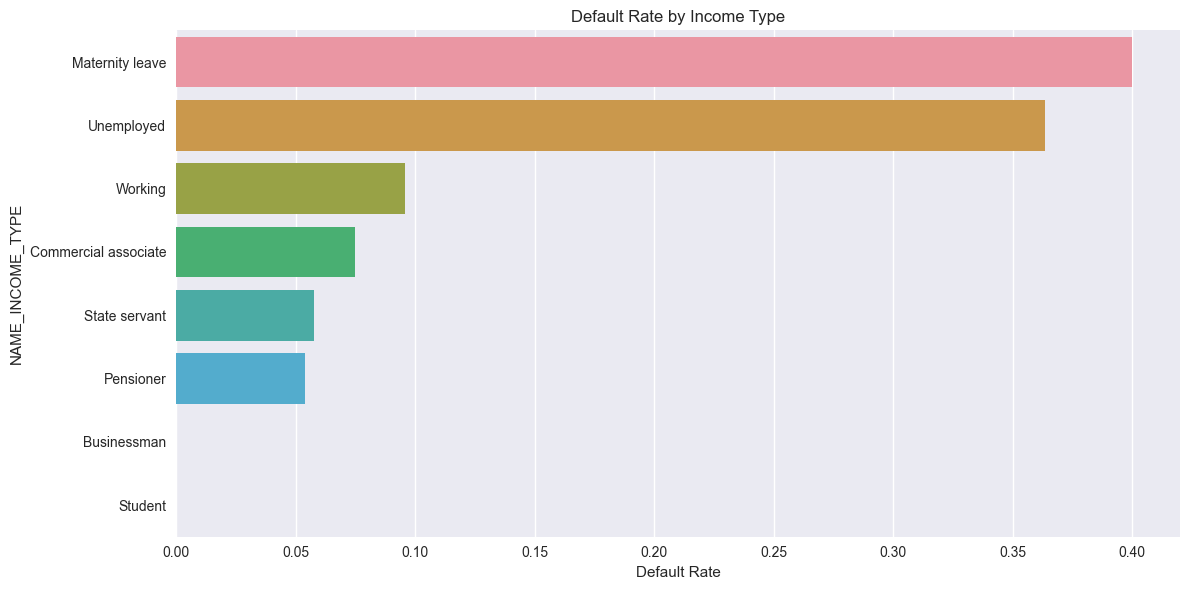


=== INSIGHT 1: PENGARUH JENIS PENDAPATAN ===
Default rate tertinggi: Maternity leave (40.00%)
Default rate terendah: Businessman (0.00%)


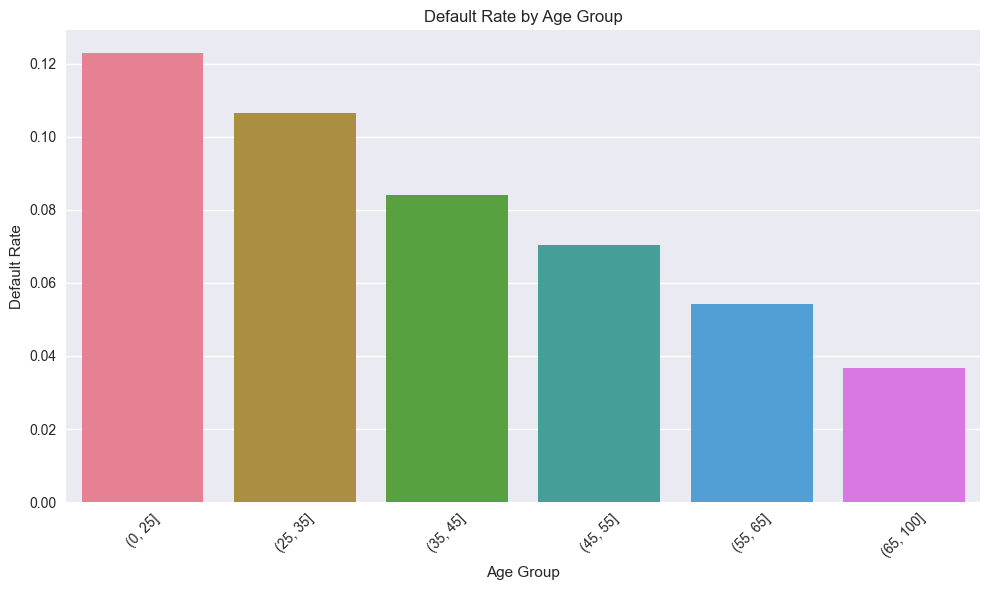


=== INSIGHT 2: PENGARUH UMUR ===
Default rate tertinggi pada age group: (0, 25] (12.29%)


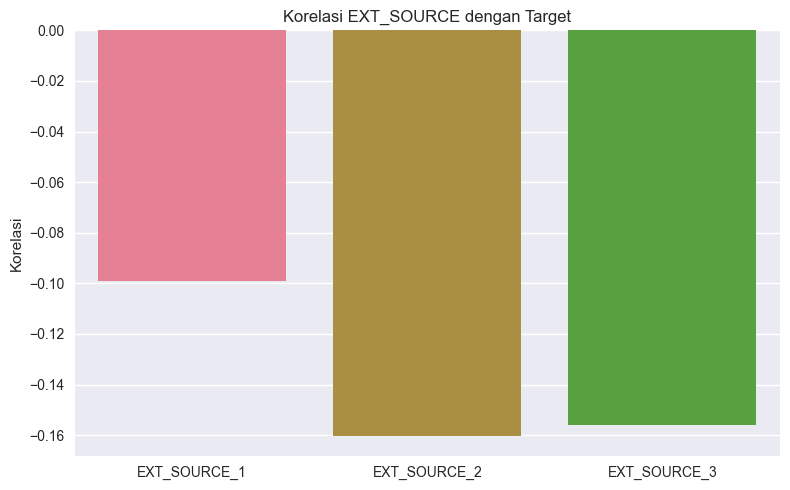


=== INSIGHT 3: PENTINGNYA EXT_SOURCE ===
EXT_SOURCE_1: -0.099
EXT_SOURCE_2: -0.160
EXT_SOURCE_3: -0.156


In [40]:
print("\n" + "="*50)
print("3. DATA VISUALIZATION & INSIGHT")
print("="*50)
# contoh: Default rate by income type (hati-hati jika kolom tidak ada)
if 'NAME_INCOME_TYPE' in app_train_final.columns and 'TARGET' in app_train_final.columns:
    plt.figure(figsize=(12, 6))
    income_type_target = app_train_final.groupby('NAME_INCOME_TYPE')['TARGET'].mean().sort_values(ascending=False)
    sns.barplot(x=income_type_target.values, y=income_type_target.index)
    plt.title('Default Rate by Income Type')
    plt.xlabel('Default Rate')
    plt.tight_layout()
    plt.show()
    print("\n=== INSIGHT 1: PENGARUH JENIS PENDAPATAN ===")
    print(f"Default rate tertinggi: {income_type_target.idxmax()} ({income_type_target.max():.2%})")
    print(f"Default rate terendah: {income_type_target.idxmin()} ({income_type_target.min():.2%})")

# Age group insight
if 'AGE' in app_train_final.columns and 'TARGET' in app_train_final.columns:
    plt.figure(figsize=(10, 6))
    app_train_final['AGE_GROUP'] = pd.cut(app_train_final['AGE'], bins=[0, 25, 35, 45, 55, 65, 100])
    age_group_target = app_train_final.groupby('AGE_GROUP')['TARGET'].mean()
    sns.barplot(x=age_group_target.index.astype(str), y=age_group_target.values)
    plt.title('Default Rate by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Default Rate')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("\n=== INSIGHT 2: PENGARUH UMUR ===")
    print(f"Default rate tertinggi pada age group: {age_group_target.idxmax()} ({age_group_target.max():.2%})")

# EXT_SOURCE correlation
if set(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','TARGET']).issubset(app_train_final.columns):
    ext_source_corr = app_train_final[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','TARGET']].corr()['TARGET'].drop('TARGET')
    plt.figure(figsize=(8,5))
    sns.barplot(x=ext_source_corr.index, y=ext_source_corr.values)
    plt.title('Korelasi EXT_SOURCE dengan Target')
    plt.ylabel('Korelasi')
    plt.tight_layout()
    plt.show()
    print("\n=== INSIGHT 3: PENTINGNYA EXT_SOURCE ===")
    for source, corr in ext_source_corr.items():
        print(f"{source}: {corr:.3f}")

## **7. Model Build and Evaluation**

Processing data for modeling by encoding categorical variables, handling infinite values, imputing missing values, and scaling. Data is divided into training and validation sets.

### **7.1 Machine Learning Model**

Implementation of traditional machine learning models - Random Forest and LightGBM. LightGBM uses early stopping and evaluation during training to prevent overfitting.

#### **7.1.1 Random Forest**


RANDOM FOREST CLASSIFIER - COMPREHENSIVE ANALYSIS
🏗️ Building Random Forest Model...

📋 RANDOM FOREST MODEL CONFIGURATION:
• n_estimators: 100
• max_depth: 10
• min_samples_split: 5
• min_samples_leaf: 3
• random_state: 42
• class_weight: balanced

🚀 Training Random Forest Model...

📊 RANDOM FOREST MODEL SUMMARY:
• Number of trees: 100
• Number of features: 134
• Feature names: 134 features
• Classes: [0 1]

✅ RANDOM FOREST PERFORMANCE METRICS:
   AUC: 0.7359
   Accuracy: 0.7276
   Precision: 0.1687
   Recall: 0.6048
   F1-Score: 0.2639

🔍 RANDOM FOREST FEATURE IMPORTANCE:
Top 10 Most Important Features:
  EXT_SOURCE_3: 0.1501
  EXT_SOURCE_2: 0.1445
  EXT_SOURCE_1: 0.0580
  BUREAU_DAYS_CREDIT_MEAN: 0.0367
  AGE: 0.0286
  BUREAU_DAYS_CREDIT_MAX: 0.0275
  YEARS_EMPLOYED: 0.0256
  DAYS_BIRTH: 0.0247
  DAYS_EMPLOYED: 0.0243
  BUREAU_AMT_CREDIT_SUM_DEBT_MEAN: 0.0223


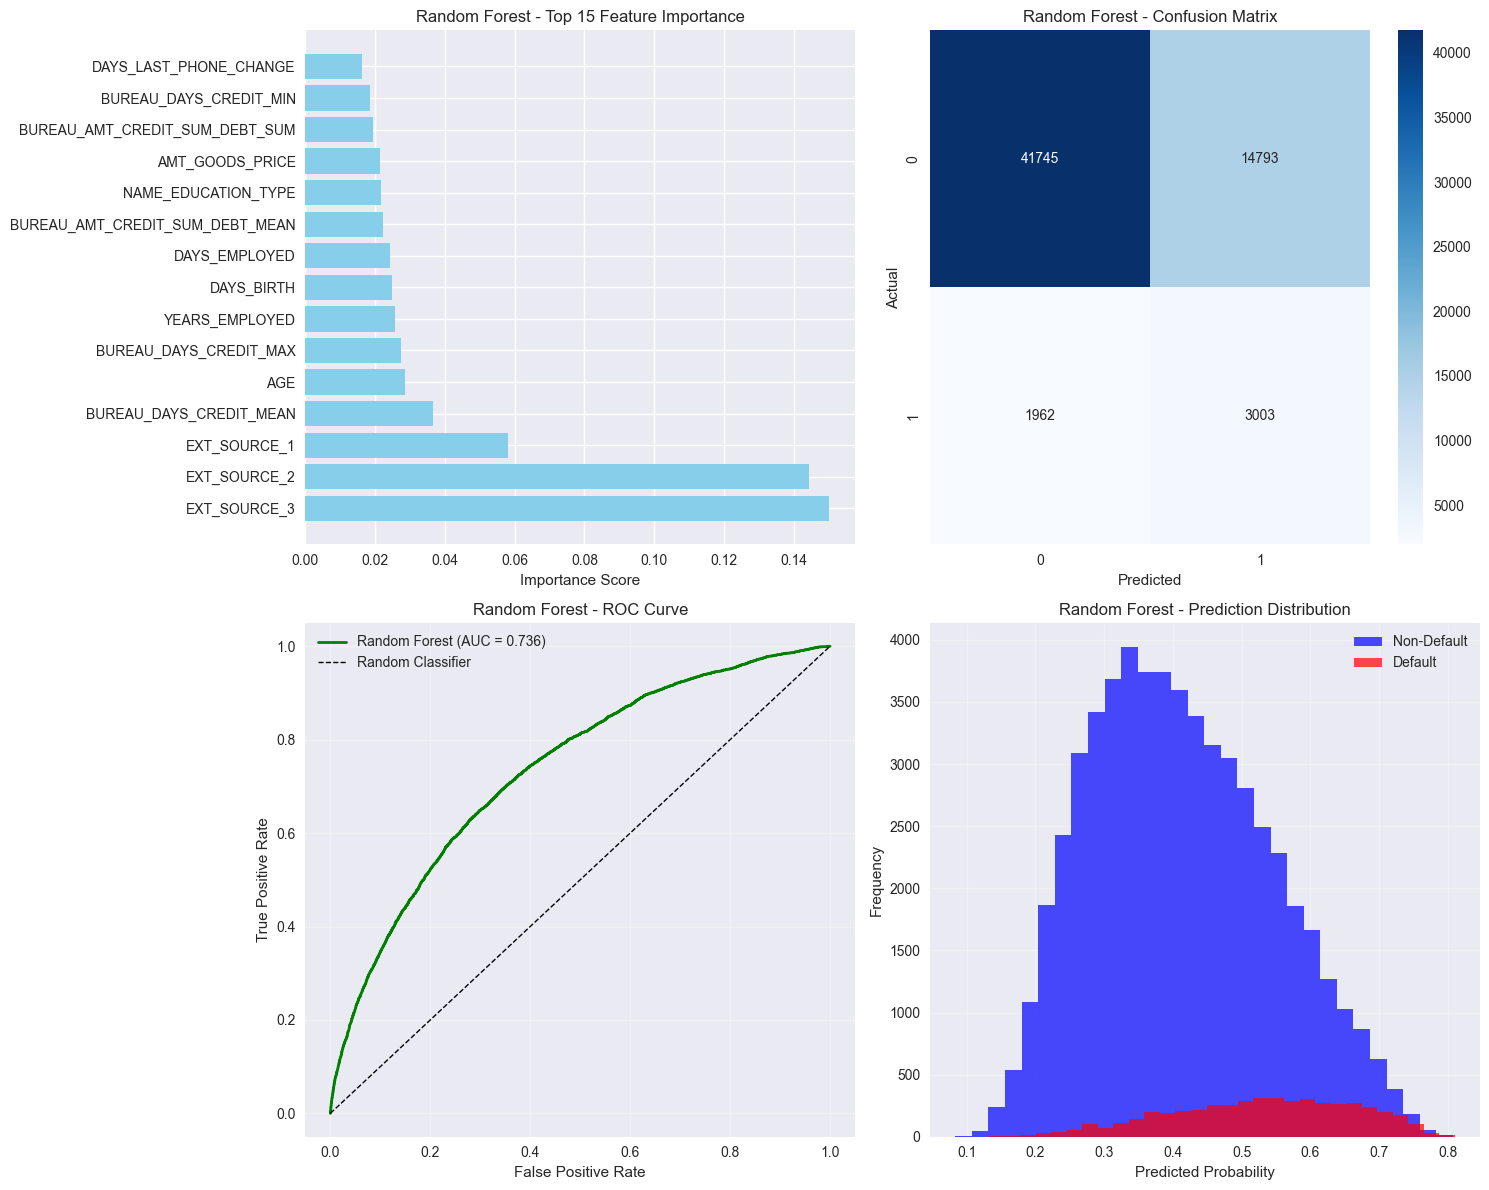


📄 RANDOM FOREST - DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Non-Default       0.96      0.74      0.83     56538
     Default       0.17      0.60      0.26      4965

    accuracy                           0.73     61503
   macro avg       0.56      0.67      0.55     61503
weighted avg       0.89      0.73      0.79     61503


🔄 Calculating Cross-Validation Score (this may take a while)...
Cross-Validation AUC Scores: [0.73090774 0.73106678 0.73445558]
Mean CV AUC: 0.7321 (+/- 0.0033)


In [41]:
print("\n" + "="*50)
print("RANDOM FOREST CLASSIFIER - COMPREHENSIVE ANALYSIS")
print("="*50)

# Build Model
print("🏗️ Building Random Forest Model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    class_weight='balanced'
)

# Display Model Configuration
print("\n📋 RANDOM FOREST MODEL CONFIGURATION:")
print(f"• n_estimators: {rf_model.n_estimators}")
print(f"• max_depth: {rf_model.max_depth}")
print(f"• min_samples_split: {rf_model.min_samples_split}")
print(f"• min_samples_leaf: {rf_model.min_samples_leaf}")
print(f"• random_state: {rf_model.random_state}")
print(f"• class_weight: {rf_model.class_weight}")

# Train Model
print("\n🚀 Training Random Forest Model...")
rf_model.fit(X_train_split, y_train_split)

# Make Predictions
rf_pred_proba = rf_model.predict_proba(X_val_split)[:, 1]
rf_pred = rf_model.predict(X_val_split)

# Calculate Metrics
rf_auc = roc_auc_score(y_val_split, rf_pred_proba)
rf_accuracy = accuracy_score(y_val_split, rf_pred)
rf_precision = precision_score(y_val_split, rf_pred)
rf_recall = recall_score(y_val_split, rf_pred)
rf_f1 = f1_score(y_val_split, rf_pred)

# Display Model Summary
print("\n📊 RANDOM FOREST MODEL SUMMARY:")
print(f"• Number of trees: {len(rf_model.estimators_)}")
print(f"• Number of features: {rf_model.n_features_in_}")
print(f"• Feature names: {len(feature_names)} features")
print(f"• Classes: {rf_model.classes_}")

# Performance Metrics
print(f"\n✅ RANDOM FOREST PERFORMANCE METRICS:")
print(f"   AUC: {rf_auc:.4f}")
print(f"   Accuracy: {rf_accuracy:.4f}")
print(f"   Precision: {rf_precision:.4f}")
print(f"   Recall: {rf_recall:.4f}")
print(f"   F1-Score: {rf_f1:.4f}")

# Feature Importance Analysis
print(f"\n🔍 RANDOM FOREST FEATURE IMPORTANCE:")
rf_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features:")
for i, row in rf_feature_importance.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance Plot
axes[0,0].barh(rf_feature_importance.head(15)['feature'], 
               rf_feature_importance.head(15)['importance'], 
               color='skyblue')
axes[0,0].set_title('Random Forest - Top 15 Feature Importance')
axes[0,0].set_xlabel('Importance Score')

# 2. Confusion Matrix
cm_rf = confusion_matrix(y_val_split, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Random Forest - Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_val_split, rf_pred_proba)
axes[1,0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})', linewidth=2, color='green')
axes[1,0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('Random Forest - ROC Curve')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Prediction Distribution
axes[1,1].hist(rf_pred_proba[y_val_split == 0], bins=30, alpha=0.7, label='Non-Default', color='blue')
axes[1,1].hist(rf_pred_proba[y_val_split == 1], bins=30, alpha=0.7, label='Default', color='red')
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Random Forest - Prediction Distribution')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed Classification Report
print("\n📄 RANDOM FOREST - DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_val_split, rf_pred, target_names=['Non-Default', 'Default']))

# Cross-Validation Score (optional - might take time)
print("\n🔄 Calculating Cross-Validation Score (this may take a while)...")
cv_scores = cross_val_score(rf_model, X_train_split, y_train_split, cv=3, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

#### **7.1.2 LightGBM**


LIGHTGBM CLASSIFIER - COMPREHENSIVE ANALYSIS
🏗️ Building LightGBM Model...

📋 LIGHTGBM MODEL CONFIGURATION:
• n_estimators: 1000
• learning_rate: 0.05
• max_depth: 7
• num_leaves: 31
• subsample: 0.8
• colsample_bytree: 0.8
• random_state: 42
• class_weight: balanced

🚀 Training LightGBM Model...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14716
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.593138
[100]	valid_0's binary_logloss: 0.5758

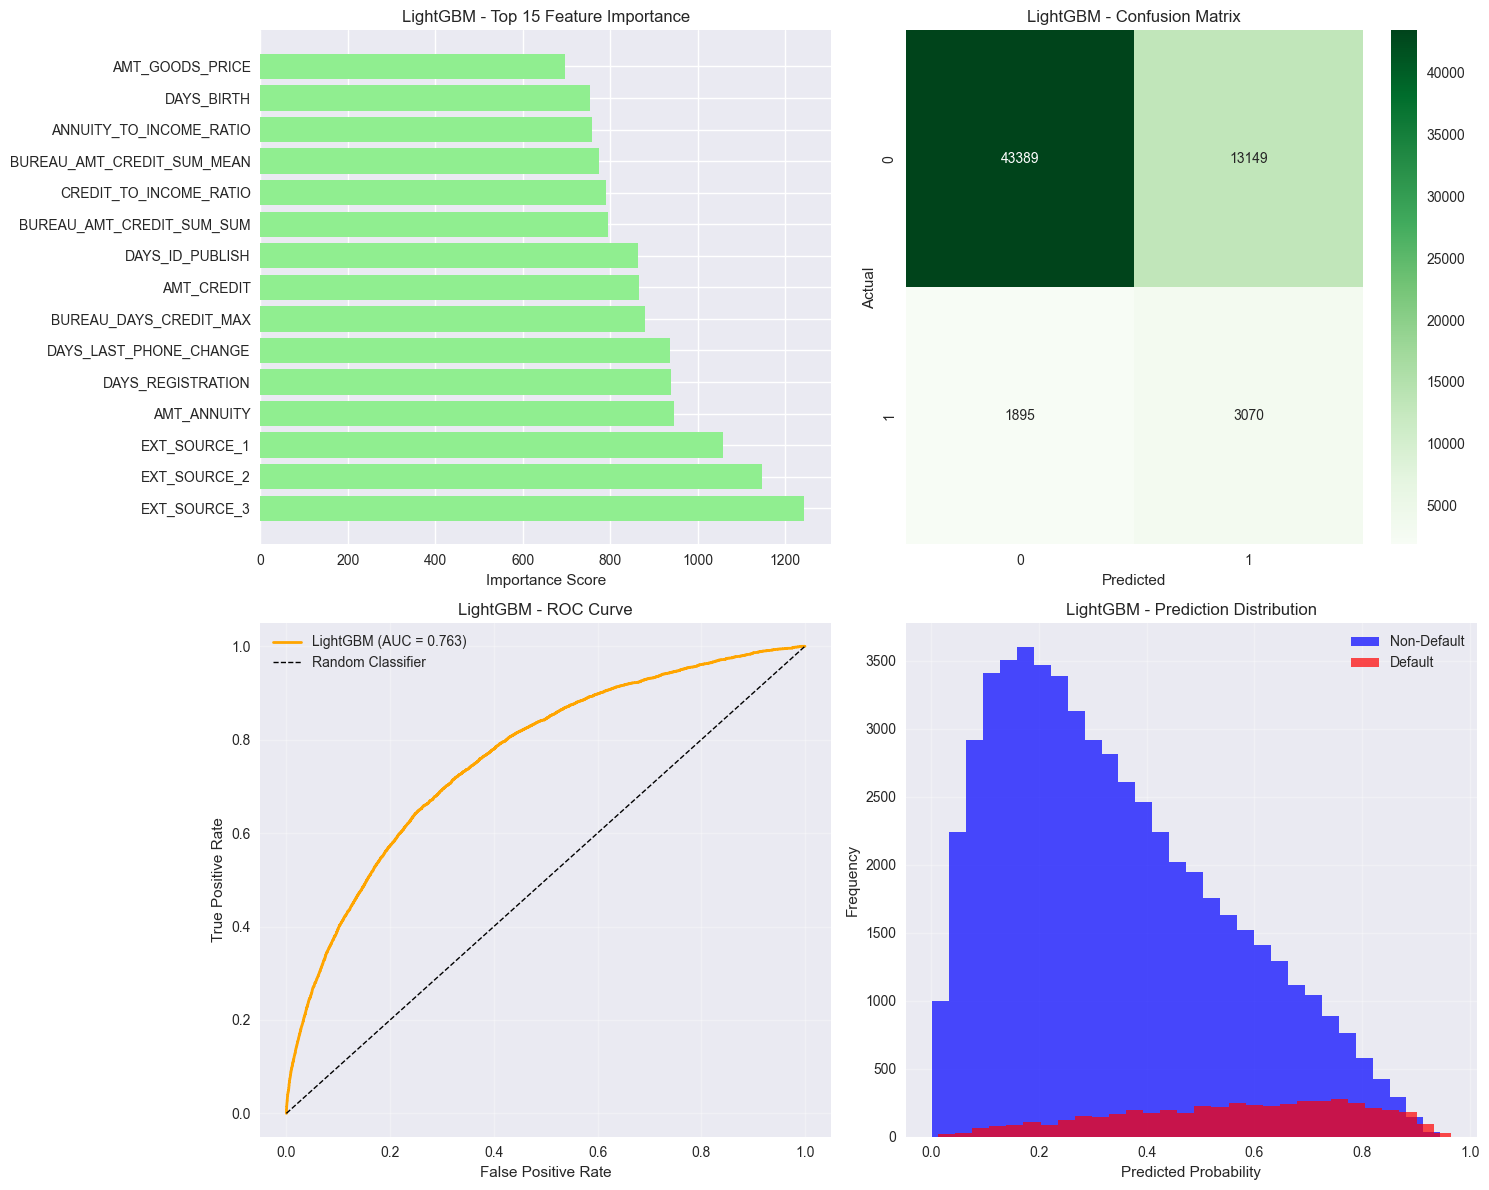


📄 LIGHTGBM - DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Non-Default       0.96      0.77      0.85     56538
     Default       0.19      0.62      0.29      4965

    accuracy                           0.76     61503
   macro avg       0.57      0.69      0.57     61503
weighted avg       0.90      0.76      0.81     61503


🆚 TRADITIONAL ML MODELS COMPARISON:
           Model     AUC  Accuracy  Precision  Recall  F1-Score
0  Random Forest  0.7359    0.7276     0.1687  0.6048    0.2639
1       LightGBM  0.7628    0.7554     0.1893  0.6183    0.2898


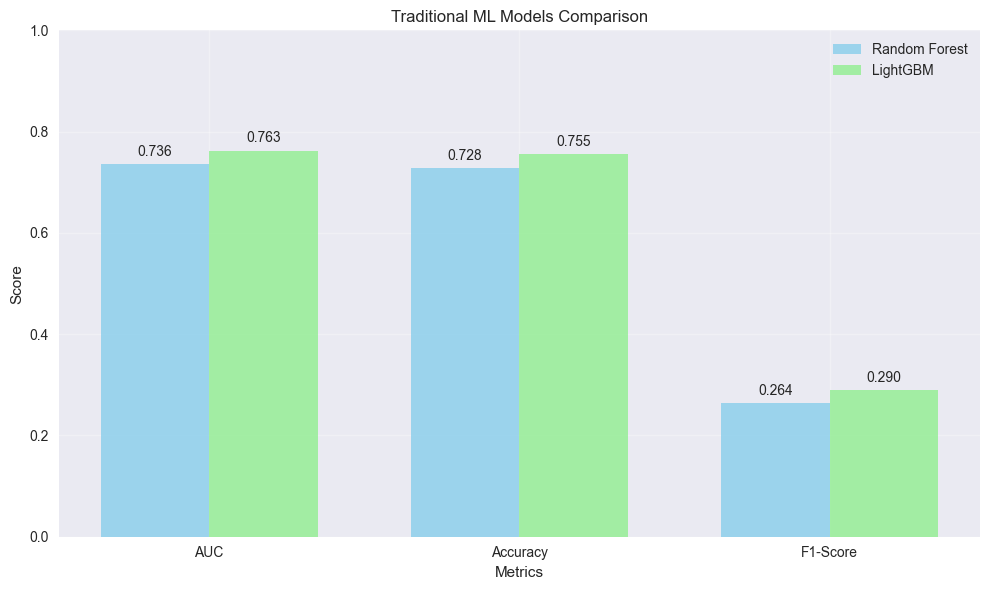

In [42]:
print("\n" + "="*50)
print("LIGHTGBM CLASSIFIER - COMPREHENSIVE ANALYSIS")
print("="*50)

# Build Model
print("🏗️ Building LightGBM Model...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced'
)

# Display Model Configuration
print("\n📋 LIGHTGBM MODEL CONFIGURATION:")
print(f"• n_estimators: {lgb_model.n_estimators}")
print(f"• learning_rate: {lgb_model.learning_rate}")
print(f"• max_depth: {lgb_model.max_depth}")
print(f"• num_leaves: {lgb_model.num_leaves}")
print(f"• subsample: {lgb_model.subsample}")
print(f"• colsample_bytree: {lgb_model.colsample_bytree}")
print(f"• random_state: {lgb_model.random_state}")
print(f"• class_weight: {lgb_model.class_weight}")

# Train Model with callbacks
print("\n🚀 Training LightGBM Model...")
lgb_training_history = lgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)

# Make Predictions
lgb_pred_proba = lgb_model.predict_proba(X_val_split)[:, 1]
lgb_pred = lgb_model.predict(X_val_split)

# Calculate Metrics
lgb_auc = roc_auc_score(y_val_split, lgb_pred_proba)
lgb_accuracy = accuracy_score(y_val_split, lgb_pred)
lgb_precision = precision_score(y_val_split, lgb_pred)
lgb_recall = recall_score(y_val_split, lgb_pred)
lgb_f1 = f1_score(y_val_split, lgb_pred)

# Display Model Summary
print("\n📊 LIGHTGBM MODEL SUMMARY:")
print(f"• Best iteration: {lgb_model.best_iteration_}")
print(f"• Number of features: {lgb_model.n_features_in_}")
print(f"• Number of classes: {lgb_model.n_classes_}")
print(f"• Feature names: {len(feature_names)} features")

# Performance Metrics
print(f"\n✅ LIGHTGBM PERFORMANCE METRICS:")
print(f"   AUC: {lgb_auc:.4f}")
print(f"   Accuracy: {lgb_accuracy:.4f}")
print(f"   Precision: {lgb_precision:.4f}")
print(f"   Recall: {lgb_recall:.4f}")
print(f"   F1-Score: {lgb_f1:.4f}")

# Feature Importance Analysis
print(f"\n🔍 LIGHTGBM FEATURE IMPORTANCE:")
lgb_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 10 features
print("Top 10 Most Important Features:")
for i, row in lgb_feature_importance.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance Plot
axes[0,0].barh(lgb_feature_importance.head(15)['feature'], 
               lgb_feature_importance.head(15)['importance'], 
               color='lightgreen')
axes[0,0].set_title('LightGBM - Top 15 Feature Importance')
axes[0,0].set_xlabel('Importance Score')

# 2. Confusion Matrix
cm_lgb = confusion_matrix(y_val_split, lgb_pred)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Greens', ax=axes[0,1])
axes[0,1].set_title('LightGBM - Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. ROC Curve
fpr_lgb, tpr_lgb, _ = roc_curve(y_val_split, lgb_pred_proba)
axes[1,0].plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {lgb_auc:.3f})', linewidth=2, color='orange')
axes[1,0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('LightGBM - ROC Curve')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Training History (if available)
if hasattr(lgb_training_history, 'history') and 'valid_0' in lgb_training_history.history:
    train_auc = lgb_training_history.history['training']['auc']
    valid_auc = lgb_training_history.history['valid_0']['auc']
    axes[1,1].plot(train_auc, label='Training AUC', color='blue')
    axes[1,1].plot(valid_auc, label='Validation AUC', color='red')
    axes[1,1].set_xlabel('Iteration')
    axes[1,1].set_ylabel('AUC Score')
    axes[1,1].set_title('LightGBM - Training History')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
else:
    # Prediction Distribution as fallback
    axes[1,1].hist(lgb_pred_proba[y_val_split == 0], bins=30, alpha=0.7, label='Non-Default', color='blue')
    axes[1,1].hist(lgb_pred_proba[y_val_split == 1], bins=30, alpha=0.7, label='Default', color='red')
    axes[1,1].set_xlabel('Predicted Probability')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('LightGBM - Prediction Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed Classification Report
print("\n📄 LIGHTGBM - DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_val_split, lgb_pred, target_names=['Non-Default', 'Default']))

# Model Comparison within Traditional ML
print("\n🆚 TRADITIONAL ML MODELS COMPARISON:")
ml_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'LightGBM'],
    'AUC': [rf_auc, lgb_auc],
    'Accuracy': [rf_accuracy, lgb_accuracy],
    'Precision': [rf_precision, lgb_precision],
    'Recall': [rf_recall, lgb_recall],
    'F1-Score': [rf_f1, lgb_f1]
})

print(ml_comparison.round(4))

# Visual comparison
plt.figure(figsize=(10, 6))
metrics = ['AUC', 'Accuracy', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

for i, metric in enumerate(metrics):
    rf_value = ml_comparison.loc[0, metric]
    lgb_value = ml_comparison.loc[1, metric]
    
    plt.bar(x[i] - width/2, rf_value, width, label='Random Forest' if i == 0 else "", color='skyblue', alpha=0.8)
    plt.bar(x[i] + width/2, lgb_value, width, label='LightGBM' if i == 0 else "", color='lightgreen', alpha=0.8)
    
    plt.text(x[i] - width/2, rf_value + 0.01, f'{rf_value:.3f}', ha='center', va='bottom')
    plt.text(x[i] + width/2, lgb_value + 0.01, f'{lgb_value:.3f}', ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Traditional ML Models Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **7.2 Deep Learning Model**

Implementation of two neural network architectures—simple feedforward and deeper networks with batch normalization. Using callbacks for early stopping and learning rate reduction.

#### **7.2.1 Simple Feedforward Network**


SIMPLE FEEDFORWARD NEURAL NETWORK
Training Simple Feedforward Neural Network...

📊 Simple NN Architecture Summary:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_input (Dense)        (None, 128)               17280     
                                                                 
 simple_dropout_1 (Dropout)  (None, 128)               0         
                                                                 
 simple_hidden_1 (Dense)     (None, 64)                8256      
                                                                 
 simple_dropout_2 (Dropout)  (None, 64)                0         
                                                                 
 simple_hidden_2 (Dense)     (None, 32)                2080      
                                                                 
 simple_output (Dense)       (None, 1)                 33        
    

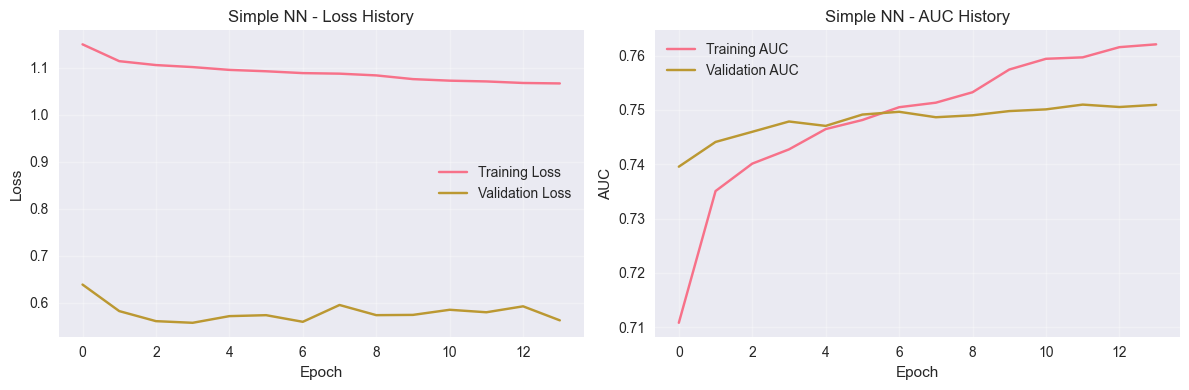

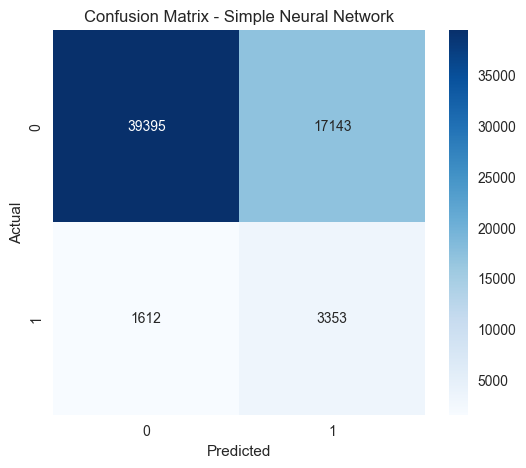

In [43]:
print("\n" + "="*50)
print("SIMPLE FEEDFORWARD NEURAL NETWORK")
print("="*50)

def create_simple_nn(input_dim):
    """
    Simple Feedforward Neural Network Architecture:
    - 3 Hidden Layers (128 -> 64 -> 32 neurons)
    - Dropout for regularization
    - ReLU activation in hidden layers
    - Sigmoid output for binary classification
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,), name='simple_input'),
        Dropout(0.3, name='simple_dropout_1'),
        Dense(64, activation='relu', name='simple_hidden_1'),
        Dropout(0.2, name='simple_dropout_2'),
        Dense(32, activation='relu', name='simple_hidden_2'),
        Dense(1, activation='sigmoid', name='simple_output')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

print("Training Simple Feedforward Neural Network...")
simple_nn_model = create_simple_nn(X_train_split.shape[1])

# Display model architecture
print("\n📊 Simple NN Architecture Summary:")
simple_nn_model.summary()

# Train Simple Neural Network
print("\n🚀 Training Simple Neural Network...")
history_simple = simple_nn_model.fit(
    X_train_split, y_train_split,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_split, y_val_split),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate Simple Neural Network
print("\n📈 Evaluating Simple Neural Network...")
simple_nn_pred_proba = simple_nn_model.predict(X_val_split).flatten()
simple_nn_pred = (simple_nn_pred_proba > 0.5).astype(int)

# Calculate metrics for Simple NN
simple_nn_auc = roc_auc_score(y_val_split, simple_nn_pred_proba)
simple_nn_accuracy = accuracy_score(y_val_split, simple_nn_pred)
simple_nn_precision = precision_score(y_val_split, simple_nn_pred)
simple_nn_recall = recall_score(y_val_split, simple_nn_pred)
simple_nn_f1 = f1_score(y_val_split, simple_nn_pred)

print(f"\n✅ SIMPLE NEURAL NETWORK PERFORMANCE:")
print(f"   AUC: {simple_nn_auc:.4f}")
print(f"   Accuracy: {simple_nn_accuracy:.4f}")
print(f"   Precision: {simple_nn_precision:.4f}")
print(f"   Recall: {simple_nn_recall:.4f}")
print(f"   F1-Score: {simple_nn_f1:.4f}")

# Plot training history for Simple NN
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_simple.history['loss'], label='Training Loss')
plt.plot(history_simple.history['val_loss'], label='Validation Loss')
plt.title('Simple NN - Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_simple.history['auc'], label='Training AUC')
plt.plot(history_simple.history['val_auc'], label='Validation AUC')
plt.title('Simple NN - AUC History')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion Matrix for Simple NN
cm_simple = confusion_matrix(y_val_split, simple_nn_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Simple Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### **7.2.2 Deeper Network with Batch Normalization**


DEEP NEURAL NETWORK WITH BATCH NORMALIZATION
Training Deep Neural Network with Batch Normalization...

📊 Deep NN Architecture Summary:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deep_input (Dense)          (None, 256)               34560     
                                                                 
 deep_bn_1 (BatchNormalizati  (None, 256)              1024      
 on)                                                             
                                                                 
 deep_dropout_1 (Dropout)    (None, 256)               0         
                                                                 
 deep_hidden_1 (Dense)       (None, 128)               32896     
                                                                 
 deep_bn_2 (BatchNormalizati  (None, 128)              512       
 on)                                              

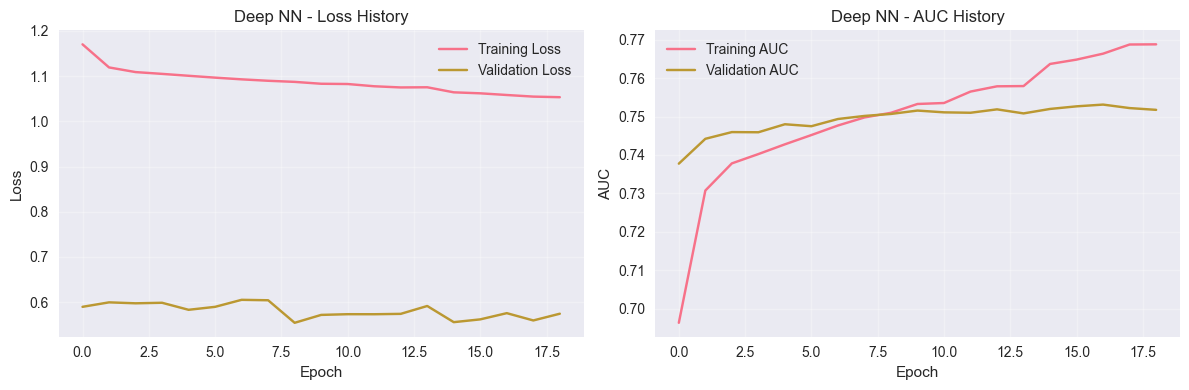

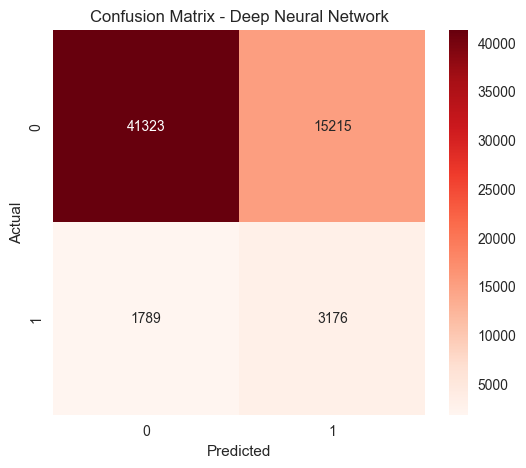

In [44]:
print("\n" + "="*50)
print("DEEP NEURAL NETWORK WITH BATCH NORMALIZATION")
print("="*50)

def create_deep_nn(input_dim):
    """
    Deep Neural Network Architecture with Batch Normalization:
    - 4 Hidden Layers (256 -> 128 -> 64 -> 32 neurons)
    - Batch Normalization after each hidden layer
    - Higher Dropout rates for regularization
    - ReLU activation in hidden layers
    - Sigmoid output for binary classification
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,), name='deep_input'),
        BatchNormalization(name='deep_bn_1'),
        Dropout(0.4, name='deep_dropout_1'),
        Dense(128, activation='relu', name='deep_hidden_1'),
        BatchNormalization(name='deep_bn_2'),
        Dropout(0.3, name='deep_dropout_2'),
        Dense(64, activation='relu', name='deep_hidden_2'),
        BatchNormalization(name='deep_bn_3'),
        Dropout(0.2, name='deep_dropout_3'),
        Dense(32, activation='relu', name='deep_hidden_3'),
        Dense(1, activation='sigmoid', name='deep_output')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

print("Training Deep Neural Network with Batch Normalization...")
deep_nn_model = create_deep_nn(X_train_split.shape[1])

# Display model architecture
print("\n📊 Deep NN Architecture Summary:")
deep_nn_model.summary()

# Train Deep Neural Network
print("\n🚀 Training Deep Neural Network...")
history_deep = deep_nn_model.fit(
    X_train_split, y_train_split,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_split, y_val_split),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate Deep Neural Network
print("\n📈 Evaluating Deep Neural Network...")
deep_nn_pred_proba = deep_nn_model.predict(X_val_split).flatten()
deep_nn_pred = (deep_nn_pred_proba > 0.5).astype(int)

# Calculate metrics for Deep NN
deep_nn_auc = roc_auc_score(y_val_split, deep_nn_pred_proba)
deep_nn_accuracy = accuracy_score(y_val_split, deep_nn_pred)
deep_nn_precision = precision_score(y_val_split, deep_nn_pred)
deep_nn_recall = recall_score(y_val_split, deep_nn_pred)
deep_nn_f1 = f1_score(y_val_split, deep_nn_pred)

print(f"\n✅ DEEP NEURAL NETWORK PERFORMANCE:")
print(f"   AUC: {deep_nn_auc:.4f}")
print(f"   Accuracy: {deep_nn_accuracy:.4f}")
print(f"   Precision: {deep_nn_precision:.4f}")
print(f"   Recall: {deep_nn_recall:.4f}")
print(f"   F1-Score: {deep_nn_f1:.4f}")

# Plot training history for Deep NN
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_deep.history['loss'], label='Training Loss')
plt.plot(history_deep.history['val_loss'], label='Validation Loss')
plt.title('Deep NN - Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_deep.history['auc'], label='Training AUC')
plt.plot(history_deep.history['val_auc'], label='Validation AUC')
plt.title('Deep NN - AUC History')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion Matrix for Deep NN
cm_deep = confusion_matrix(y_val_split, deep_nn_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_deep, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Deep Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **8. Model Comparison and Evaluation**

Compare the performance of all models using various metrics (AUC, Accuracy, Precision, Recall, F1-Score). Visualize ROC curves and training history for comprehensive analysis.


=== MODEL PERFORMANCE COMPARISON ===
Random Forest AUC: 0.7359
LightGBM AUC: 0.7628
Simple Neural Network AUC: 0.7479
Deep Neural Network AUC: 0.7507

=== DETAILED METRICS COMPARISON ===
           Model     AUC  Accuracy  Precision  Recall  F1-Score
0  Random Forest  0.7359    0.7276     0.1687  0.6048    0.2639
1       LightGBM  0.7628    0.7554     0.1893  0.6183    0.2898
2      Simple NN  0.7479    0.6951     0.1636  0.6753    0.2634
3        Deep NN  0.7507    0.7235     0.1727  0.6397    0.2720

📊 CREATING COMPREHENSIVE MODEL COMPARISON VISUALIZATIONS...


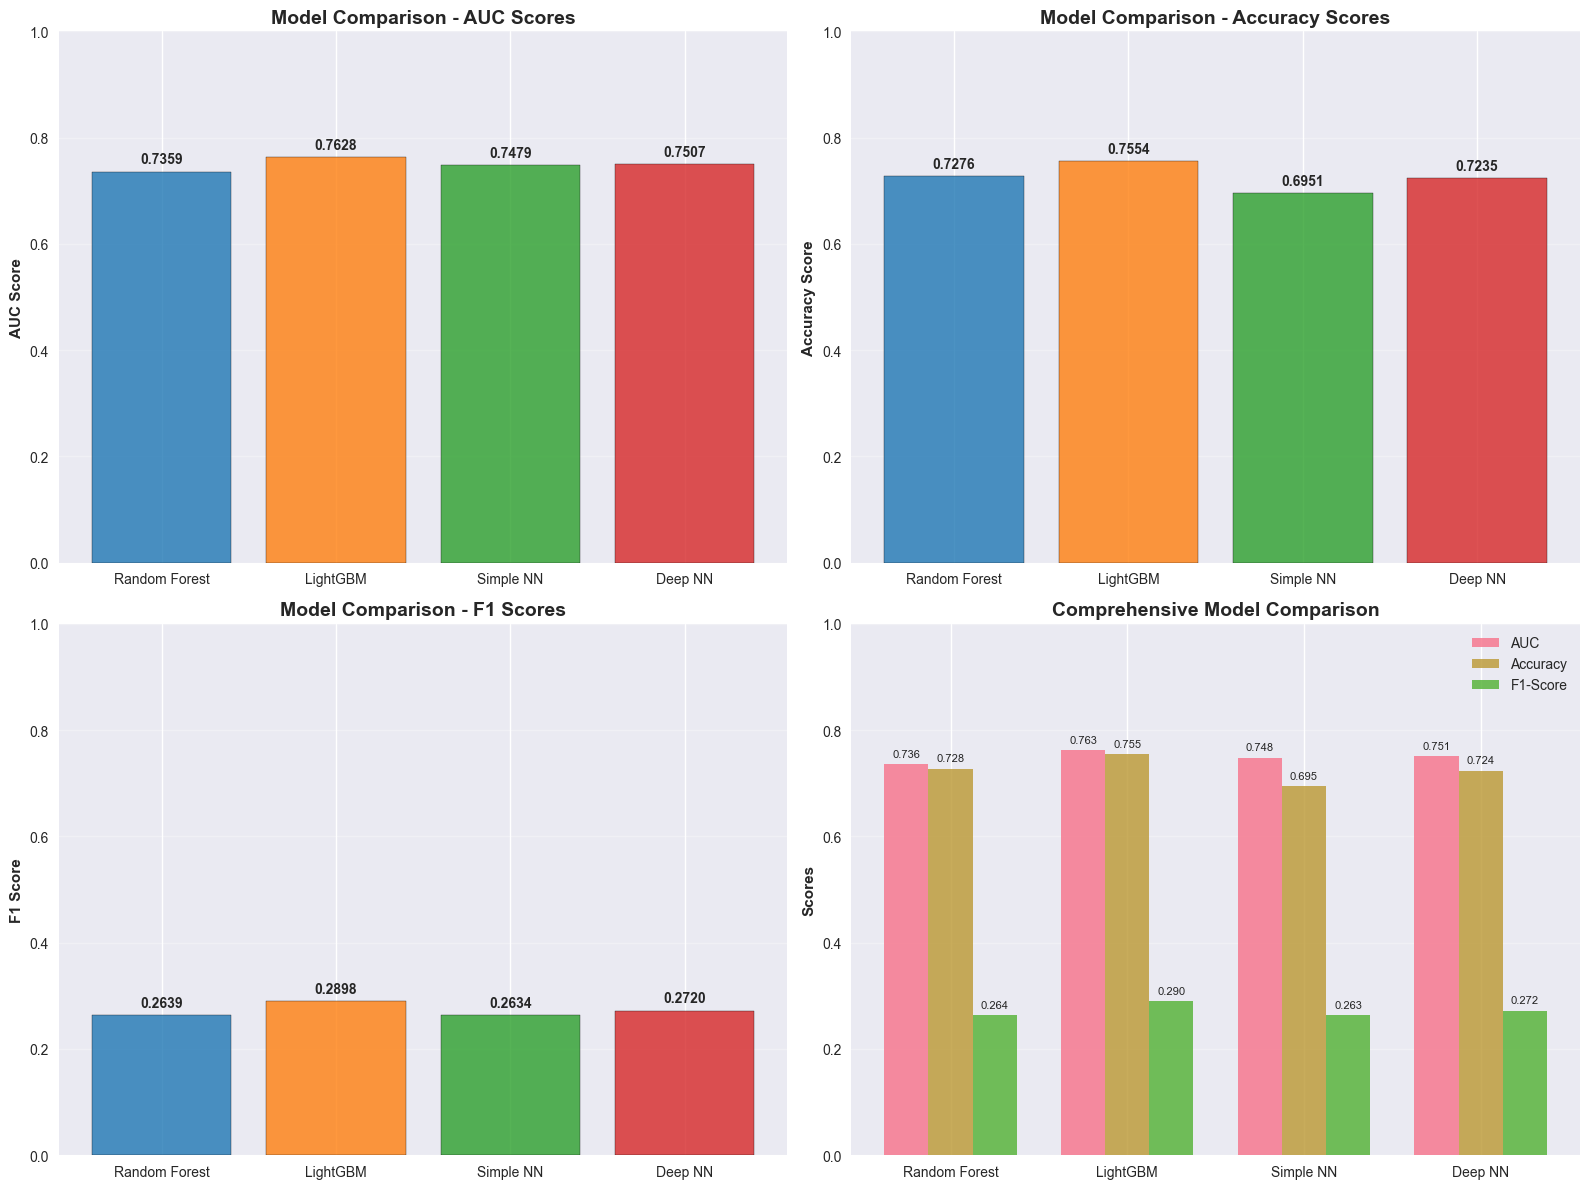

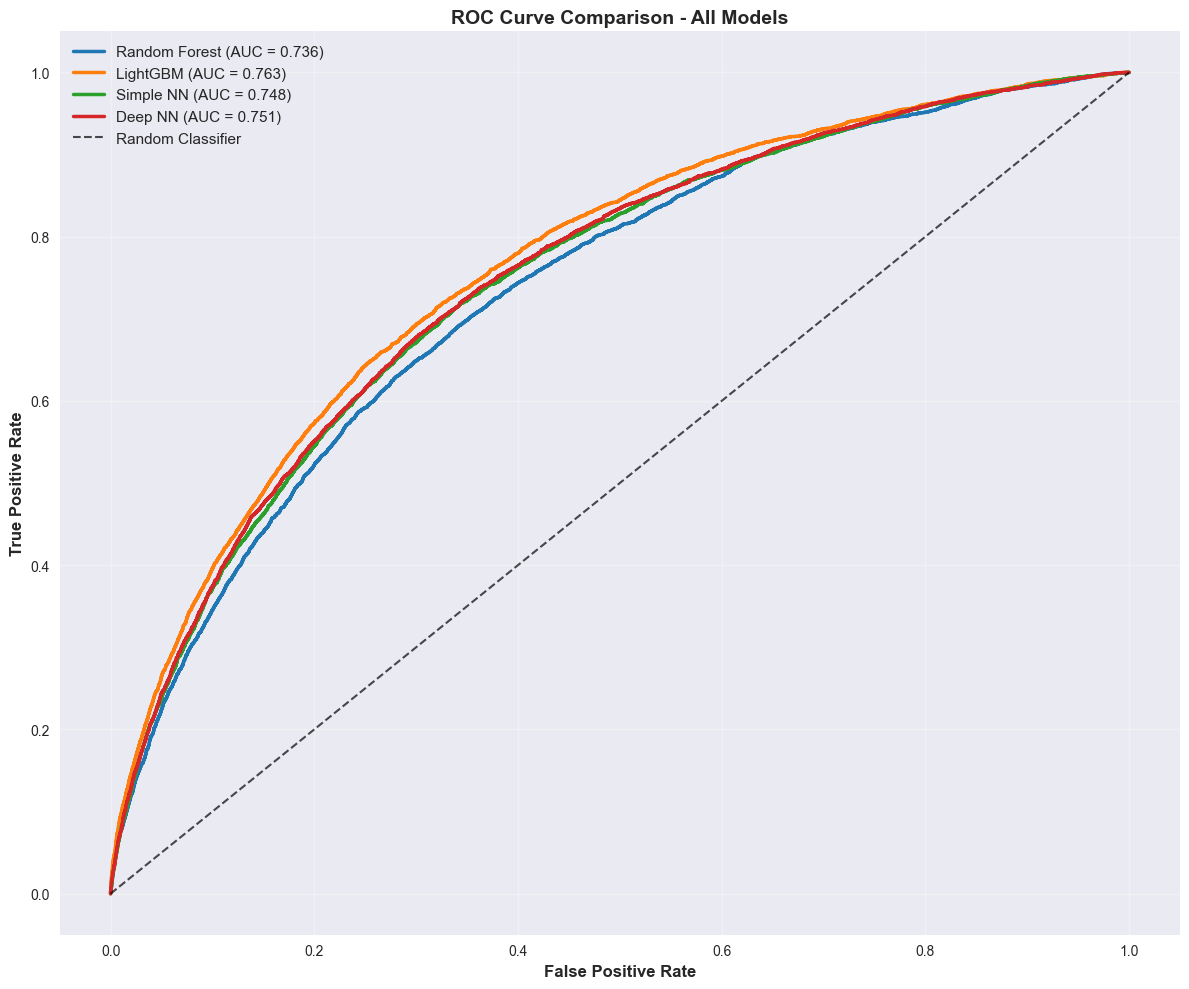


📈 CREATING RADAR CHART FOR MODEL COMPARISON...


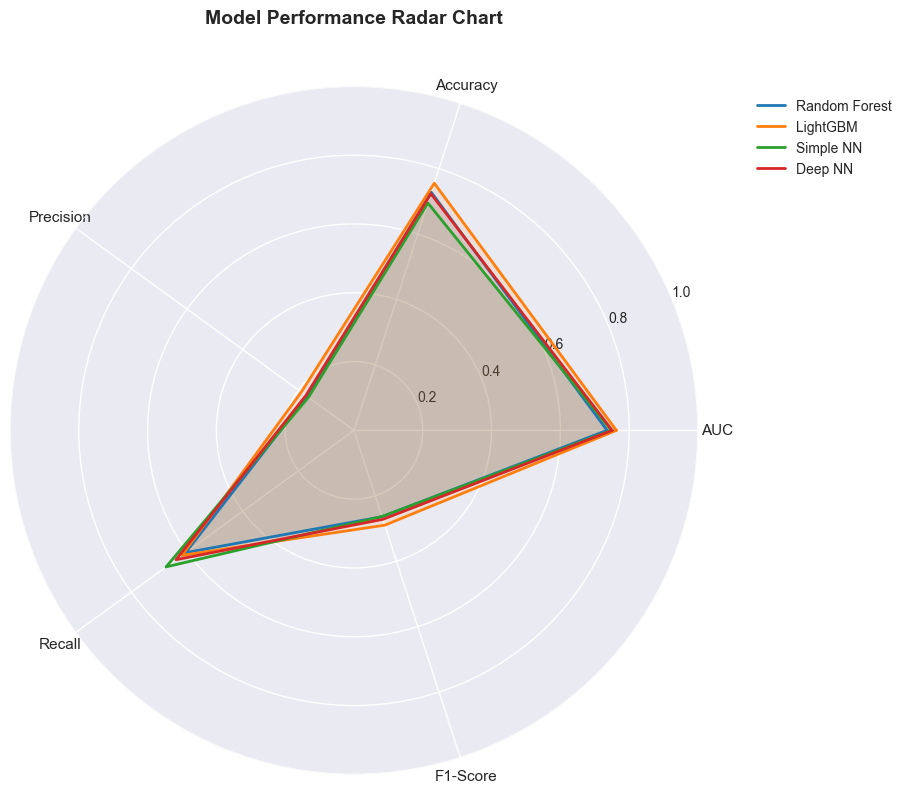

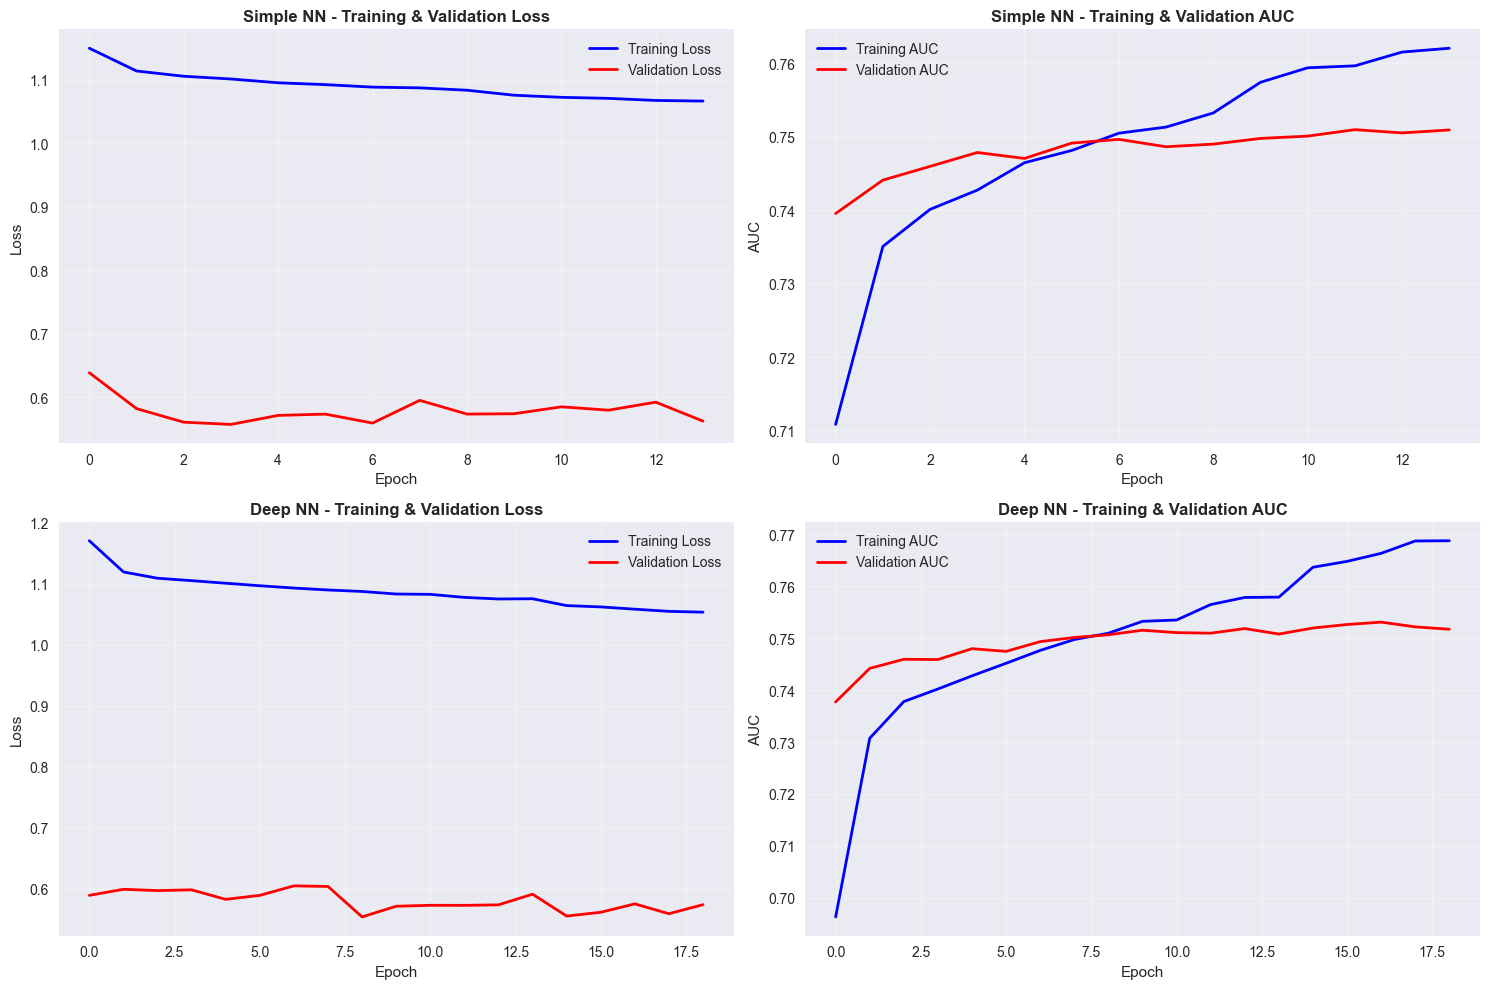

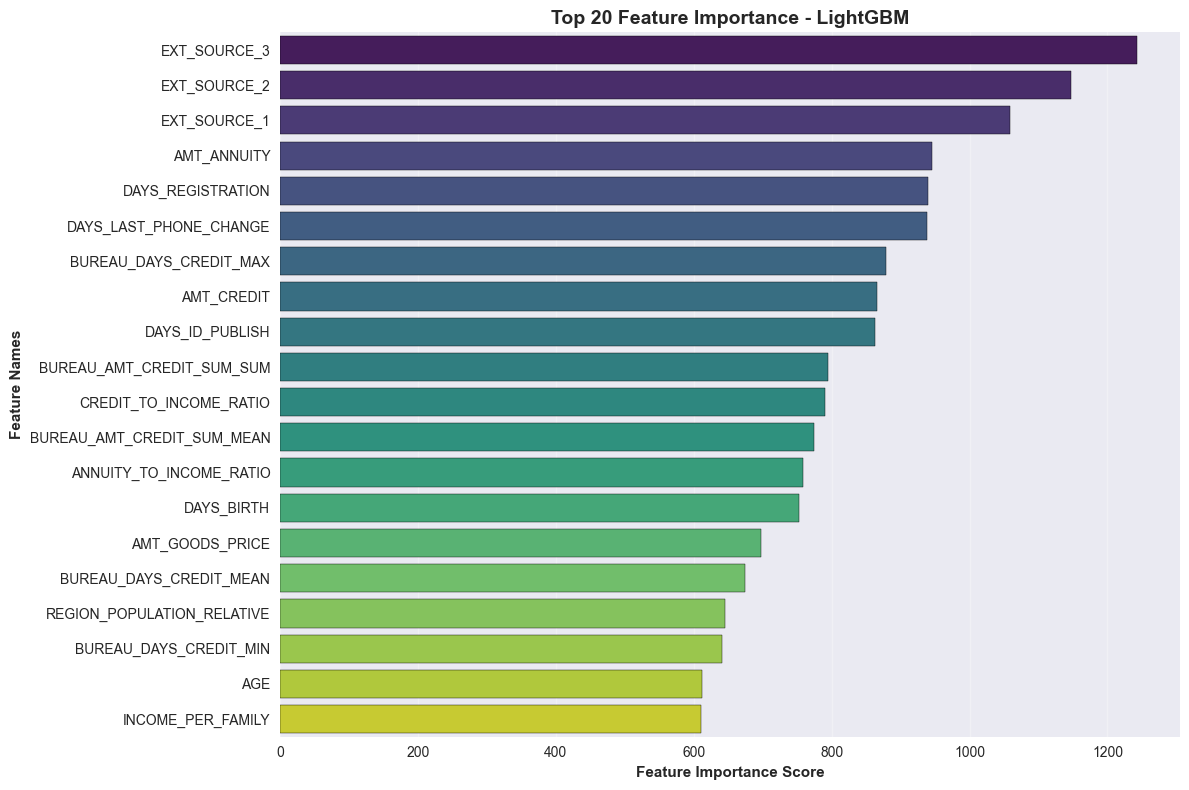


🏆 FINAL MODEL RANKING AND SUMMARY

📈 MODEL RANKING (by AUC):
1. LightGBM: AUC = 0.7628, Accuracy = 0.7554
2. Deep NN: AUC = 0.7507, Accuracy = 0.7235
3. Simple NN: AUC = 0.7479, Accuracy = 0.6951
4. Random Forest: AUC = 0.7359, Accuracy = 0.7276

🎯 BEST PERFORMING MODEL: LightGBM
   • AUC: 0.7628
   • Accuracy: 0.7554
   • F1-Score: 0.2898
   • AUC advantage over 2nd place: 0.0121

📊 OVERALL PERFORMANCE RANGE:
   • AUC: 0.7359 - 0.7628
   • Accuracy: 0.6951 - 0.7554
   • F1-Score: 0.2634 - 0.2898

✅ Model comparison completed successfully!


In [45]:
print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(f"Random Forest AUC: {rf_auc:.4f}")
print(f"LightGBM AUC: {lgb_auc:.4f}")
print(f"Simple Neural Network AUC: {simple_nn_auc:.4f}")
print(f"Deep Neural Network AUC: {deep_nn_auc:.4f}")

# Calculate additional metrics for comparison
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    return {
        'Model': model_name,
        'AUC': roc_auc_score(y_true, y_pred_proba),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

# Create comparison table
metrics_comparison = pd.DataFrame([
    calculate_metrics(y_val_split, rf_pred, rf_pred_proba, 'Random Forest'),
    calculate_metrics(y_val_split, lgb_pred, lgb_pred_proba, 'LightGBM'),
    calculate_metrics(y_val_split, simple_nn_pred, simple_nn_pred_proba, 'Simple NN'),
    calculate_metrics(y_val_split, deep_nn_pred, deep_nn_pred_proba, 'Deep NN')
])

print("\n=== DETAILED METRICS COMPARISON ===")
print(metrics_comparison.round(4))

# ============================================================================
# VISUALIZATION 1: BAR CHARTS FOR MODEL COMPARISON
# ============================================================================
print("\n📊 CREATING COMPREHENSIVE MODEL COMPARISON VISUALIZATIONS...")

# Create comprehensive comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. AUC Comparison Bar Chart
models = metrics_comparison['Model']
auc_scores = metrics_comparison['AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Distinct colors

bars1 = axes[0,0].bar(models, auc_scores, color=colors, alpha=0.8, edgecolor='black')
axes[0,0].set_title('Model Comparison - AUC Scores', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('AUC Score', fontweight='bold')
axes[0,0].set_ylim(0, 1)
axes[0,0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars1, auc_scores):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Accuracy Comparison Bar Chart
accuracy_scores = metrics_comparison['Accuracy']
bars2 = axes[0,1].bar(models, accuracy_scores, color=colors, alpha=0.8, edgecolor='black')
axes[0,1].set_title('Model Comparison - Accuracy Scores', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Accuracy Score', fontweight='bold')
axes[0,1].set_ylim(0, 1)
axes[0,1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars2, accuracy_scores):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. F1-Score Comparison Bar Chart
f1_scores = metrics_comparison['F1-Score']
bars3 = axes[1,0].bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black')
axes[1,0].set_title('Model Comparison - F1 Scores', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('F1 Score', fontweight='bold')
axes[1,0].set_ylim(0, 1)
axes[1,0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars3, f1_scores):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 4. Multi-Metric Comparison (All metrics in one chart)
metrics_to_plot = ['AUC', 'Accuracy', 'F1-Score']
x = np.arange(len(models))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    offset = width * i
    values = metrics_comparison[metric]
    rects = axes[1,1].bar(x + offset, values, width, label=metric, alpha=0.8)
    
    # Add value labels
    for rect, value in zip(rects, values):
        height = rect.get_height()
        axes[1,1].text(rect.get_x() + rect.get_width()/2., height + 0.01,
                      f'{value:.3f}', ha='center', va='bottom', fontsize=8)

axes[1,1].set_title('Comprehensive Model Comparison', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Scores', fontweight='bold')
axes[1,1].set_xticks(x + width)
axes[1,1].set_xticklabels(models)
axes[1,1].legend()
axes[1,1].set_ylim(0, 1)
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 2: ROC CURVE COMPARISON
# ============================================================================
plt.figure(figsize=(12, 10))
fpr_rf, tpr_rf, _ = roc_curve(y_val_split, rf_pred_proba)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val_split, lgb_pred_proba)
fpr_simple_nn, tpr_simple_nn, _ = roc_curve(y_val_split, simple_nn_pred_proba)
fpr_deep_nn, tpr_deep_nn, _ = roc_curve(y_val_split, deep_nn_pred_proba)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})', linewidth=2.5, color='#1f77b4')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {lgb_auc:.3f})', linewidth=2.5, color='#ff7f0e')
plt.plot(fpr_simple_nn, tpr_simple_nn, label=f'Simple NN (AUC = {simple_nn_auc:.3f})', linewidth=2.5, color='#2ca02c')
plt.plot(fpr_deep_nn, tpr_deep_nn, label=f'Deep NN (AUC = {deep_nn_auc:.3f})', linewidth=2.5, color='#d62728')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5, alpha=0.7)

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve Comparison - All Models', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 3: PERFORMANCE RADAR CHART
# ============================================================================
print("\n📈 CREATING RADAR CHART FOR MODEL COMPARISON...")

# Create radar chart for comprehensive comparison
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

# Metrics for radar chart (normalized to 0-1 scale)
metrics_radar = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
num_metrics = len(metrics_radar)

# Calculate angles for each axis
angles = [n / float(num_metrics) * 2 * np.pi for n in range(num_metrics)]
angles += angles[:1]  # Complete the circle

# Plot each model
for i, model in enumerate(models):
    values = metrics_comparison[metrics_radar].iloc[i].tolist()
    values += values[:1]  # Complete the circle
    ax.plot(angles, values, linewidth=2, label=model, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_radar, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart', size=14, fontweight='bold', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 4: TRAINING HISTORY FOR NEURAL NETWORKS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Simple NN - Loss History
axes[0,0].plot(history_simple.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0,0].plot(history_simple.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
axes[0,0].set_title('Simple NN - Training & Validation Loss', fontweight='bold')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Simple NN - AUC History
axes[0,1].plot(history_simple.history['auc'], label='Training AUC', linewidth=2, color='blue')
axes[0,1].plot(history_simple.history['val_auc'], label='Validation AUC', linewidth=2, color='red')
axes[0,1].set_title('Simple NN - Training & Validation AUC', fontweight='bold')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('AUC')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Deep NN - Loss History
axes[1,0].plot(history_deep.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[1,0].plot(history_deep.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
axes[1,0].set_title('Deep NN - Training & Validation Loss', fontweight='bold')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Loss')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Deep NN - AUC History
axes[1,1].plot(history_deep.history['auc'], label='Training AUC', linewidth=2, color='blue')
axes[1,1].plot(history_deep.history['val_auc'], label='Validation AUC', linewidth=2, color='red')
axes[1,1].set_title('Deep NN - Training & Validation AUC', fontweight='bold')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('AUC')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 5: FEATURE IMPORTANCE
# ============================================================================
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), 
            palette='viridis', edgecolor='black')
plt.title('Top 20 Feature Importance - LightGBM', fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance Score', fontweight='bold')
plt.ylabel('Feature Names', fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# FINAL SUMMARY AND RANKING
# ============================================================================
print("\n" + "="*60)
print("🏆 FINAL MODEL RANKING AND SUMMARY")
print("="*60)

# Sort models by AUC (descending)
ranked_models = metrics_comparison.sort_values('AUC', ascending=False)

print("\n📈 MODEL RANKING (by AUC):")
for i, (idx, row) in enumerate(ranked_models.iterrows(), 1):
    print(f"{i}. {row['Model']}: AUC = {row['AUC']:.4f}, Accuracy = {row['Accuracy']:.4f}")

# Best model
best_model = ranked_models.iloc[0]
print(f"\n🎯 BEST PERFORMING MODEL: {best_model['Model']}")
print(f"   • AUC: {best_model['AUC']:.4f}")
print(f"   • Accuracy: {best_model['Accuracy']:.4f}")
print(f"   • F1-Score: {best_model['F1-Score']:.4f}")

# Performance gaps
if len(ranked_models) > 1:
    second_best = ranked_models.iloc[1]
    auc_gap = best_model['AUC'] - second_best['AUC']
    print(f"   • AUC advantage over 2nd place: {auc_gap:.4f}")

print(f"\n📊 OVERALL PERFORMANCE RANGE:")
print(f"   • AUC: {metrics_comparison['AUC'].min():.4f} - {metrics_comparison['AUC'].max():.4f}")
print(f"   • Accuracy: {metrics_comparison['Accuracy'].min():.4f} - {metrics_comparison['Accuracy'].max():.4f}")
print(f"   • F1-Score: {metrics_comparison['F1-Score'].min():.4f} - {metrics_comparison['F1-Score'].max():.4f}")

print("\n✅ Model comparison completed successfully!")

## **9. Predictions on Test Data and Submission**

Perform predictions on the test data using all trained models and create an ensemble prediction. Results are stored in the competition submission file.

In [46]:
print("\n" + "="*50)
print("PREDICTION ON TEST DATA")
print("="*50)

X_test_scaled, _, test_feature_names, _, _ = prepare_modeling_data(app_test_final, is_train=False)

# Predict using all models for comparison
rf_test_predictions = rf_model.predict_proba(X_test_scaled)[:, 1]
lgb_test_predictions = lgb_model.predict_proba(X_test_scaled)[:, 1]
simple_nn_test_predictions = simple_nn_model.predict(X_test_scaled).flatten()
deep_nn_test_predictions = deep_nn_model.predict(X_test_scaled).flatten()

# Create ensemble prediction (average of all models)
ensemble_test_predictions = (lgb_test_predictions + simple_nn_test_predictions + deep_nn_test_predictions) / 3

# Save predictions from best model (LightGBM based on AUC)
submission = pd.DataFrame({
    'SK_ID_CURR': app_test_final['SK_ID_CURR'],
    'TARGET': lgb_test_predictions
})
submission.to_csv('home_credit_submission.csv', index=False)

# Also save ensemble predictions
ensemble_submission = pd.DataFrame({
    'SK_ID_CURR': app_test_final['SK_ID_CURR'],
    'TARGET': ensemble_test_predictions
})
ensemble_submission.to_csv('home_credit_ensemble_submission.csv', index=False)

print("Submission files saved:")
print("- 'home_credit_submission.csv' (LightGBM predictions)")
print("- 'home_credit_ensemble_submission.csv' (Ensemble predictions)")
print(f"Predictions completed for {len(submission)} test samples")


PREDICTION ON TEST DATA
1524/1524 [==============================] - 3s 2ms/step
Submission files saved:
- 'home_credit_submission.csv' (LightGBM predictions)
- 'home_credit_ensemble_submission.csv' (Ensemble predictions)
Predictions completed for 48744 test samples


## **11. Conclusion and Final Analysis**

Presents the final conclusions of the analysis, compares the performance of all models, and provides insight into the advantages and disadvantages of each approach.

In [49]:
print("\n" + "="*50)
print("KESIMPULAN DAN PERBANDINGAN MODEL")
print("="*50)

# Find best model
best_model_idx = metrics_comparison['AUC'].idxmax()
best_model = metrics_comparison.loc[best_model_idx]

if 'TARGET' in app_train_final.columns:
    print("• Default rate keseluruhan: {:.2%}".format(app_train_final['TARGET'].mean()))

print("\n• PERFORMANCE MODEL (diurutkan berdasarkan AUC):")
metrics_comparison_sorted = metrics_comparison.sort_values('AUC', ascending=False)
for idx, row in metrics_comparison_sorted.iterrows():
    print(f"  {row['Model']}: AUC = {row['AUC']:.4f}, F1-Score = {row['F1-Score']:.4f}")

print(f"\n• MODEL TERBAIK: {best_model['Model']}")
print(f"  - AUC: {best_model['AUC']:.4f}")
print(f"  - Accuracy: {best_model['Accuracy']:.4f}")
print(f"  - F1-Score: {best_model['F1-Score']:.4f}")


KESIMPULAN DAN PERBANDINGAN MODEL
• Default rate keseluruhan: 8.07%

• PERFORMANCE MODEL (diurutkan berdasarkan AUC):
  LightGBM: AUC = 0.7628, F1-Score = 0.2898
  Deep NN: AUC = 0.7507, F1-Score = 0.2720
  Simple NN: AUC = 0.7479, F1-Score = 0.2634
  Random Forest: AUC = 0.7359, F1-Score = 0.2639

• MODEL TERBAIK: LightGBM
  - AUC: 0.7628
  - Accuracy: 0.7554
  - F1-Score: 0.2898
